## The CIC-IoV-2024 Experiment! 

In [1]:
import os
import sys
import vote
import time
import pickle
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.io as pio
import plotly.graph_objs as go
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

In [2]:
repo_dir = "cic-iov-2024"
if not os.path.exists(repo_dir):
    !git clone https://github.com/val-co/cic-iov-2024.git

DATASET_DIRECTORY = '/home/ubuntu/IDS/' + repo_dir + '/'

In [3]:
# Dictionary to store dataframes
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(DATASET_DIRECTORY):
    
    # Check if the file is a CSV
    if filename.endswith('.csv'):
        
        # Generate the variable name from the filename (remove '.csv')
        var_name = os.path.splitext(filename)[0]
        
        # Read the CSV file into a DataFrame
        file_path = os.path.join(DATASET_DIRECTORY, filename)
        dataframes[var_name] = pd.read_csv(file_path)
        
        # Drop the last 2 columns
        dataframes[var_name] = dataframes[var_name].iloc[:, :-2]
        
        # Identify the third last column
        third_last_col = dataframes[var_name].columns[-1]
        
        # Replace values in the third last column
        dataframes[var_name][third_last_col] = dataframes[var_name][third_last_col].replace({'ATTACK': 1, 'BENIGN': 0})

# Optionally, print the variables to verify
for var_name, df in dataframes.items():
    print(f"DataFrame '{var_name}'")

DataFrame 'decimal_spoofing-GAS'
DataFrame 'decimal_spoofing-SPEED'
DataFrame 'decimal_spoofing-RPM'
DataFrame 'decimal_spoofing-STEERING_WHEEL'
DataFrame 'decimal_DoS'
DataFrame 'decimal_benign'


In [4]:
from sklearn.model_selection import train_test_split

test_df, test_l_df = {}, {}

# Initialize empty DataFrames for combined datasets
X_train = pd.DataFrame()
X_valid = pd.DataFrame()
X_test = pd.DataFrame()

# Initialize empty Series for target variables
y_train = pd.Series(dtype='int')
y_valid = pd.Series(dtype='int')
y_test = pd.Series(dtype='int')

# Split each DataFrame and combine the splits
for var_name, df in dataframes.items():
    X = df.iloc[:, :-1]  # All columns except the last one
    y = df.iloc[:, -1]   # The last column
    
    X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_valid_temp, X_test_temp, y_valid_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    
    test_df[var_name] = X_test_temp
    test_l_df[var_name] = y_test_temp
    
    # Combine the splits into the respective datasets
    X_train = pd.concat([X_train, X_train_temp])
    X_valid = pd.concat([X_valid, X_valid_temp])
    X_test = pd.concat([X_test, X_test_temp])
    
    y_train = pd.concat([y_train, y_train_temp])
    y_valid = pd.concat([y_valid, y_valid_temp])
    y_test = pd.concat([y_test, y_test_temp])

# Optionally, print the shapes of the combined datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (844929, 9)
y_train shape: (844929,)

X_valid shape: (422465, 9)
y_valid shape: (422465,)

X_test shape: (140825, 9)
y_test shape: (140825,)


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training data
X_train_scaled = scaler.transform(X_train)

# Transform the validation data
X_valid_scaled = scaler.transform(X_valid)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

model1 = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=42)
print("Models Training")
model1.fit(X_train_scaled, y_train)
print("Models Trained")

Models Training
Models Trained


In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef

y_pred = []
    
y_pred = model1.predict(X_test_scaled)
    
print("\nModel Metrics")
print('accuracy_score: {:.3f}'.format(accuracy_score(y_pred, y_test)))
print('recall_score: {:.3f}'.format(recall_score(y_pred, y_test)))
print('precision_score: {:.3f}'.format(precision_score(y_pred, y_test)))
print('f1_score: {:.3f}'.format(f1_score(y_pred, y_test)))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
TP = confusion_matrix_result[1, 1]  
FP = confusion_matrix_result[0, 1]  
FN = confusion_matrix_result[1, 0]  
TN = confusion_matrix_result[0, 0] 

# Print the rates
print("\nConfusion Matrix")
print("True Positive Rate (Sensitivity): {:.3f}".format(TP / (TP + FN))) 
print("True Negative Rate (Specificity): {:.3f}".format(TN / (FP + TN))) 
print("False Positive Rate (Type I Error): {:.3f}".format(FP / (FP + TN))) 
print("False Negative Rate (Type II Error): {:.3f}".format(FN / (TP + FN)), "\n") 
print("Matthews Corelation Coefficient: {:.3f}".format(matthews_corrcoef(y_pred, y_test)))
print("AUC:", roc_auc_score(y_pred, y_test))


Model Metrics
accuracy_score: 1.000
recall_score: 1.000
precision_score: 1.000
f1_score: 1.000

Confusion Matrix
True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 1.000
False Positive Rate (Type I Error): 0.000
False Negative Rate (Type II Error): 0.000 

Matthews Corelation Coefficient: 1.000
AUC: 1.0


In [ ]:
%%script echo skipping

import vote
import functools

print("Analyzing IDS for Vulnerabilities")

X_test_nr = []
y_test_nr = []

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

e = vote.Ensemble.from_sklearn(model1)
delta = 0.005
passe = 0

for i in tqdm(range(len(X_test_scaled))):
    xvec = X_test_scaled[i]
    label = y_test.iloc[i]
    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
        continue
    domain = [(max(0.0, x-delta), min(1.0, x+delta)) for x in xvec]
    checker = functools.partial(label_checker, label)
    passed = e.absref(checker, domain)
    if not passed:
        X_test_nr.append(xvec)
        y_test_nr.append(label)
    else:
        passe += 1 
     
print('IDS Robustness: {:.3f}'.format(passe/len(X_test_scaled)))

skipping


In [ ]:
%%script echo skipping

X_verif = np.concatenate((X_valid_scaled, X_train_scaled))
y_verif = np.concatenate((y_valid, y_train))

print(X_verif.shape, y_verif.shape)

skipping


In [ ]:
%%script echo skipping
import portion as P

combined_intervals_1 = [P.empty() for _ in range(e.nb_inputs)] # Attack Regions
combined_intervals_0 = [P.empty() for _ in range(e.nb_inputs)] # Benign Regions

e = vote.Ensemble.from_sklearn(model1)

for i in tqdm(range(len(X_verif))):
    xvec = X_verif[i]
    label = y_verif[i]

    def check_robustness_1(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
          for dim in range(e.nb_inputs):
            combined_intervals_1[dim] = combined_intervals_1[dim] | P.closed(m.inputs[dim].lower, m.inputs[dim].upper)
          return vote.PASS # Because we want to keep checking the input space despite finding a violation
        return o

    def check_robustness_0(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
          for dim in range(e.nb_inputs):
            combined_intervals_0[dim] = combined_intervals_0[dim] | P.closed(m.inputs[dim].lower, m.inputs[dim].upper)
          return vote.PASS # Because we want to keep checking the input space despite finding a violation
        return o

    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
      continue

    if model1.predict([np.asarray(xvec)]) == 1: # If this sample was an attack, how can we make the model robust
      input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]
      e.absref(check_robustness_1, input_region)

    if model1.predict([np.asarray(xvec)]) == 0: # If this sample was benign, how can we make the model robust
      input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]
      e.absref(check_robustness_0, input_region)

print("Attack & Benign Robustifying Regions Generated")

skipping


In [ ]:
%%script echo skipping

with open('X_test_nr_iov.pkl', 'wb') as f1:
    pickle.dump(X_test_nr,f1) 
    
with open('y_test_nr_iov.pkl', 'wb') as f2:
    pickle.dump(y_test_nr,f2) 

skipping


In [ ]:
%%script echo skipping

with open('combined_intervals_1_iov.pkl', 'wb') as f1:
    pickle.dump(combined_intervals_1,f1) 
    
with open('combined_intervals_0_iov.pkl', 'wb') as f2:
    pickle.dump(combined_intervals_0,f2) 

skipping


In [ ]:
with open('X_test_nr_iov.pkl', 'rb') as f1:
    X_test_nr = pickle.load(f1)

with open('y_test_nr_iov.pkl', 'rb') as f2:
    y_test_nr = pickle.load(f2)

In [ ]:
from collections import Counter

adversarial_examples = []
true_labels = []
delta = 0.005

e = vote.Ensemble.from_sklearn(model1)

for i in tqdm(range(len(y_test_nr))): 
    xvec = X_test_nr[i]
    label = y_test_nr[i] 
    
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL:
            if label==0:
                np.random.seed(42)
                center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                assert(model1.predict([center]) != label)
                adversarial_examples.append(center)
                true_labels.append(label)
            if label==1:
                np.random.seed(42)
                center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                assert(model1.predict([center]) != label)
                adversarial_examples.append(center)
                true_labels.append(label)
        return o
        
    
    input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]     
    e.absref(check_robustness, input_region)
    
print("Adversarial Examples: ", Counter(true_labels))

100%|██████████| 1518/1518 [00:04<00:00, 342.06it/s]

Adversarial Examples:  Counter({1: 1518})


In [ ]:
import pickle

with open('combined_intervals_1_iov.pkl', 'rb') as f1:
    combined_intervals_1 = pickle.load(f1)

with open('combined_intervals_0_iov.pkl', 'rb') as f2:
    combined_intervals_0 = pickle.load(f2)

In [ ]:
from sklearn.inspection import permutation_importance

perm_set = np.concatenate((X_train_scaled, X_valid_scaled))
perm_lab = np.concatenate((y_train, y_valid))

perm_importance = permutation_importance(model1, perm_set, perm_lab, random_state=12345, n_repeats=5, n_jobs=-1)
wv = perm_importance['importances_mean']

In [ ]:
def distance(samples):
    distances = []
    preds = model1.predict(np.asarray(samples))
    for sample, pred in zip(np.asarray(samples), preds):
        if pred == 1:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_0[i] for i in range(e.nb_inputs)]))
        else:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_1[i] for i in range(e.nb_inputs)]))
    return distances

## Now we add VERITAS into the mix!

In [ ]:
import veritas

def veritas_attack(model, samples, labels, epsilon, timeout=1, search_steps=100, verbose=False):
    adversarial_examples, true_labels = [], []
    assert len(np.unique(np.asarray(y_test))), "Input must be a binary-classification problem with labels 0/1"
    assert np.min(X_test_nr)>=0 and np.max(X_test_nr)<=1.0, "Input Dataset must be Min-Max Normalised"
    at = veritas.get_addtree(model)
    print("\nFinding Adversarial Examples using Veritas:")
    for i in tqdm(range(len(labels))):
        base_example = samples[i]
        true_label = labels[i]
        if model.predict([base_example]) != true_label:
            if verbose:
                print(i, "Skipping Misclassified Sample","\n")
            continue
        heur = veritas.HeuristicType.MAX_OUTPUT if true_label == 0 else veritas.HeuristicType.MIN_OUTPUT
        config = veritas.Config(heur)
        config.ignore_state_when_worse_than = 0.0
        prune_box = [veritas.Interval(max(0.0, x-epsilon), min(1.0, x+epsilon)) for x in base_example]
        search = config.get_search(at, prune_box)
        stop_reason = search.step_for(timeout, search_steps) 
        while search.num_solutions() == 0:
            if search.steps(search_steps) == veritas.StopReason.NO_MORE_OPEN or stop_reason:
                if verbose:
                    print(i, "Timeout & Skipped","\n") 
                break
        if search.num_solutions() > 0:
            sol = search.get_solution(0)
            adv_example = veritas.get_closest_example(sol, base_example, eps=1e-4)
            predicted_label = int(model.predict([adv_example]))
            l_inf = np.max(np.abs(base_example - adv_example))
            if int(predicted_label) != int(true_label) and l_inf < epsilon:
                adversarial_examples.append(adv_example)
                true_labels.append(true_label)
                if verbose:
                    print(i, "True Label:", str(true_label), "--> Adversarial Label:", str(predicted_label), "L-inf:", l_inf, "\n")
            else:
                if verbose:
                    print(i, "Debugging Needed","\n") 
        else:
            if verbose:
                pass
                print(i, "No Adversarial Example Found","\n")
    print("\nFound:", len(adversarial_examples), "| Split:", Counter(true_labels))
    return adversarial_examples, true_labels

In [ ]:
adversarial_examples_new, true_labels_new = veritas_attack(model1, X_test_nr, y_test_nr, delta)

SKLEARN: RF classifier with 1 classes

Finding Adversarial Examples using Veritas:


  0%|          | 0/1518 [00:00<?, ?it/s]

100%|██████████| 1518/1518 [00:08<00:00, 183.25it/s]


Found: 518 | Split: Counter({1: 518})


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

adversarial_examples_cat = np.concatenate((adversarial_examples, adversarial_examples_new))
true_labels_cat = np.concatenate((true_labels, true_labels_new))

size = len(adversarial_examples_cat)

# Initialize the undersampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: int(size/2), 1: int(size/2)}, random_state=42)
X_sampled, y_sampled = rus.fit_resample(X_test_scaled, y_test)

test_set = np.concatenate((X_sampled, adversarial_examples_cat))
test_lab_sym = np.concatenate((np.zeros(len(y_sampled), dtype=bool), np.ones(len(true_labels_cat), dtype=bool)))

test_lab = np.concatenate((y_sampled, true_labels_cat))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 4072


In [ ]:
distances_X_test  = distance(X_sampled)
distances_adversarial_examples = distance(adversarial_examples_cat)

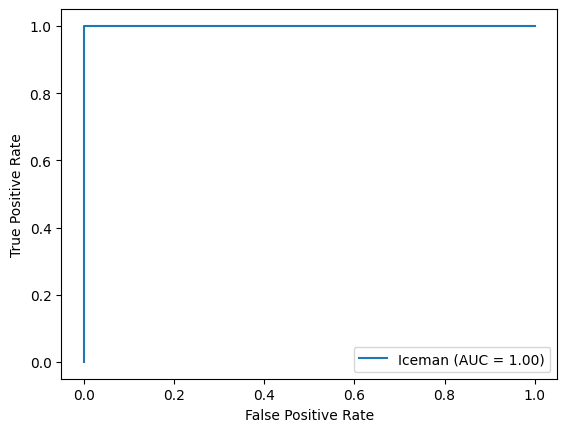

0.18


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

S = np.concatenate((distances_X_test, distances_adversarial_examples))

fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Iceman')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx],3)
print(threshold)

## Then we evaluate using Iceman! 

In [ ]:
def IDS(x, threshold):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions


In [ ]:
y_pred = IDS(test_set, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("Equal Error Rate: ", round(eer,3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  1.0 
F1-Score:  1.0 
MCC:  1.0
Rec:  1.0 
Prec:  1.0 
AUC:  1.0
Equal Error Rate:  0.0
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


## Alert Management Stuff!

In [ ]:
true_positives = X_sampled[y_sampled == 1] # True Attack. Investigate!
true_negatives = X_sampled[y_sampled == 0] # True Benign. Do Nothing!
false_positives = [example for example, label in zip(adversarial_examples_cat, true_labels_cat) if label == 0] # Evasion (true_label = benign, pred = attack). Caution!
false_negatives = [example for example, label in zip(adversarial_examples_cat, true_labels_cat) if label == 1] # Evasion (true_label = attack, pred = benign). Investigate!

print("Number of False Positives:", len(false_positives))

exp_newset = np.concatenate((true_positives, true_negatives, false_negatives))
exp_newlab = np.concatenate((np.full(len(true_positives), 1), np.full(len(true_negatives), 0), np.full(len(false_negatives), 2)))

Number of False Positives: 0


In [ ]:
def IDS_alert(x, threshold, filter = False):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            if pred == 1:
                predictions.append('tp' if filter else 1) # TP
            else:
                predictions.append('tn' if filter else 0) # TN
        else:
            if pred == 1:
                predictions.append('fp' if filter else 3) # FP
            else:
                predictions.append('fn' if filter else 2) # FN
    return predictions

In [ ]:
from sklearn.metrics import classification_report

y_pred = IDS_alert(exp_newset, threshold)

# Print classification report
print(classification_report(exp_newlab, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1018
           1       1.00      1.00      1.00      1018
           2       1.00      1.00      1.00      2036

    accuracy                           1.00      4072
   macro avg       1.00      1.00      1.00      4072
weighted avg       1.00      1.00      1.00      4072



In [ ]:
exp_newlab_filter = np.concatenate((np.full(len(true_positives), 'tp'), np.full(len(true_negatives), 'tn'), np.full(len(false_negatives), 'fn')))

y_pred = IDS_alert(exp_newset, threshold, filter=True)

# Print classification report
print(classification_report(exp_newlab_filter, y_pred))

              precision    recall  f1-score   support

          fn       1.00      1.00      1.00      2036
          tn       1.00      1.00      1.00      1018
          tp       1.00      1.00      1.00      1018

    accuracy                           1.00      4072
   macro avg       1.00      1.00      1.00      4072
weighted avg       1.00      1.00      1.00      4072



## Then we evaluate using GROOT!

In [ ]:
from groot.model import GrootRandomForestClassifier
forest = GrootRandomForestClassifier(n_estimators=25, max_depth=10, attack_model = [delta] * X_train.shape[1], random_state=42, verbose=True, n_jobs=10)

forest.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed:   14.1s finished


GrootRandomForestClassifier(attack_model=[0.005, 0.005, 0.005, 0.005, 0.005,
                                          0.005, 0.005, 0.005, 0.005],
                            max_depth=10, n_estimators=25, n_jobs=10,
                            random_state=42, verbose=True)

In [ ]:
y_pred = forest.predict(test_set)

In [ ]:
from sklearn.metrics import roc_auc_score

print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc_score(y_pred, test_lab), 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.735 
F1-Score:  0.842 
MCC:  0.091
Rec:  0.761 
Prec:  0.944 
AUC:  0.578
True Positive Rate (TPR): 0.944
True Negative Rate (TNR): 0.110
False Positive Rate (FPR): 0.890
False Negative Rate (FNR): 0.056


## Then we evaluate using OC-Score!

In [ ]:
ytrain_pred = model1.predict(X_train) # For the Reference Set
acc_train = accuracy_score(y_train, ytrain_pred)
print(f"Training Accuracy: {acc_train:.3f}")

Training Accuracy: 0.869


In [ ]:
# Find a reference set, e.g. set of correctly classified training examples
xref_mask = ytrain_pred == y_train
xref = X_train[xref_mask]
dtype = np.uint16
idref_train = model1.apply(xref).astype(dtype)

In [ ]:
exp_df = pd.DataFrame(test_set, columns=X_test.columns)
idref_exp = model1.apply(exp_df).astype(dtype)

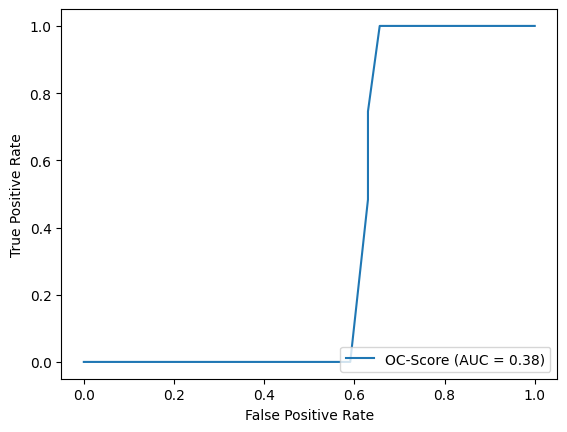

10


In [ ]:
import ocscore

S = ocscore.ocscores(idref_train, idref_exp)

fpr, tpr, thresholds = roc_curve(test_lab_sym, S, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OC-Score')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx], 3)
print(threshold)

In [ ]:
def OC_predict(x, refset, threshold):
    x = pd.DataFrame(x, columns=X_test.columns)
    testset = model1.apply(x).astype(dtype)
    S = ocscore.ocscores(refset, testset)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = OC_predict(test_set, idref_train, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.558 
F1-Score:  0.628 
MCC:  0.207
Rec:  0.851 
Prec:  0.497 
AUC:  0.376
True Positive Rate (TPR): 0.497
True Negative Rate (TNR): 0.740
False Positive Rate (FPR): 0.260
False Negative Rate (FNR): 0.503


## Timing Experiments!

In [ ]:
runs = 100

In [ ]:
times_4_iceman = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = IDS(test_set, threshold=0.4997)
    times_4_iceman.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_4_iceman.pkl', 'wb') as f:
    pickle.dump(times_4_iceman, f)
print("Complete!")

Complete!


In [ ]:
times_4_groot = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = forest.predict(test_set)
    times_4_groot.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_4_groot.pkl', 'wb') as f:
    pickle.dump(times_4_groot, f)
print("Complete!")

Complete!


In [ ]:
times_4_ocscore = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = OC_predict(test_set, idref_train, threshold)
    times_4_ocscore.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_4_ocscore.pkl', 'wb') as f:
    pickle.dump(times_4_ocscore, f)
print("Complete!")

Complete!
